In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

### Импорты и проверка данных

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, spearmanr, pearsonr, chi2_contingency
from scipy.stats import ttest_ind, f_oneway, mannwhitneyu, kruskal
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# fn = "/content/drive/MyDrive/yandex_ad_group_folder/data_3.csv"
fn = 'data_3.csv'
df = pd.read_csv(fn, delimiter=";")
df.head(5)

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,температура_удовлетворительная_%,количество_рекламаций_кат,возраст_кат,rh_кат
0,2010,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Вентиляция,Механическое отопление,55.0,Женский,...,0,-1,-1,0,22.0,0,56.2,мало,средний возраст,норма
1,2010,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Вентиляция,Механическое отопление,55.0,Женский,...,0,0,0,0,22.0,0,56.2,мало,средний возраст,норма
2,2010,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Вентиляция,Механическое отопление,45.0,Женский,...,0,-1,-1,0,22.0,0,56.2,мало,средний возраст,норма
3,2010,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Вентиляция,Механическое отопление,45.0,Женский,...,0,0,0,0,22.0,0,56.2,мало,средний возраст,норма
4,2010,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Вентиляция,Механическое отопление,55.0,Женский,...,0,-1,-1,0,22.0,0,56.2,мало,средний возраст,более_60


In [5]:
df.columns

Index(['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения',
       'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст',
       'пол', 'ощущение_температуры', 'ощущение_температуры_(bool)',
       'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_(bool)',
       'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта',
       'утепление', 'температура_воздуха_в_помещении',
       'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес',
       'занавески', 'вентилятор', 'окно', 'двери', 'отопление',
       'среднемесячная_температура_на_улице', 'количество_рекламаций',
       'температура_удовлетворительная_%', 'количество_рекламаций_кат',
       'возраст_кат', 'rh_кат'],
      dtype='object')

### Статистические функции для корреляций

In [6]:
def is_normal_distribution(column, pvalue=0.05):
    result = shapiro(column)
    if result.pvalue >= pvalue:
        return True
    return False

In [7]:
is_normal_distribution(column=df["возраст"])

False

In [8]:
def corr_for_two_numeric(column_1, column_2, after_zero=3):
    if is_normal_distribution(column_1) and is_normal_distribution(column_2):
        result = pearsonr(column_1, column_2)
        method = "pearsonr"
    else:
        result = spearmanr(column_1, column_2)
        method = "spearmanr"
    corr_coef = float(np.round(result.statistic, after_zero))
    pval = float(np.round(result.pvalue, after_zero))
    return corr_coef, pval, method

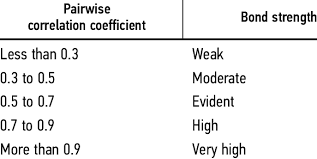

In [9]:
corr_for_two_numeric(df["возраст"], df["количество_рекламаций"])

(-0.179, 0.0, 'spearmanr')

In [10]:
def corr_for_two_nominal(column_1, column_2, after_zero=3):
    current_table = pd.crosstab(column_1, column_2)
    chi_2 = chi2_contingency(current_table)
    corr = float(np.round(chi_2.statistic, after_zero))
    pval = float(np.round(chi_2.pvalue, after_zero))
    return corr, pval

In [11]:
corr_for_two_nominal(df["возраст_кат"], df["rh_кат"])

(19.901, 0.001)

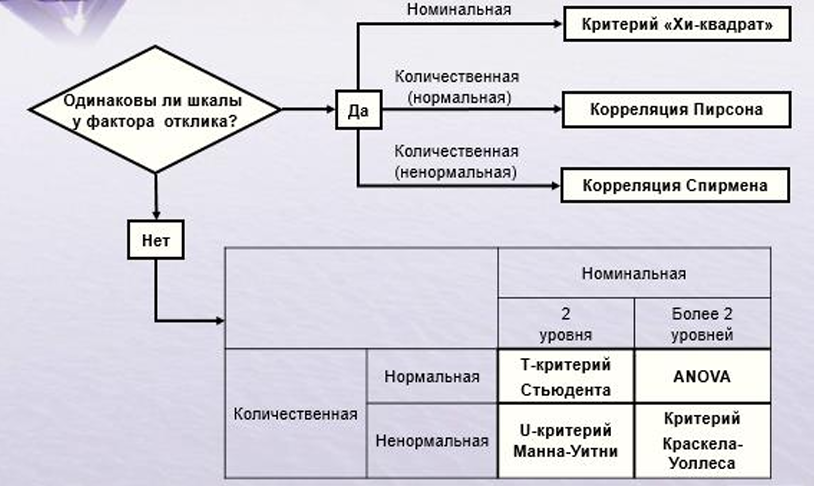

In [12]:
def corr_for_numeric_and_nominal(column_numeric, column_nominal, dataframe=df, after_zero=3):

    result = None
    method = None

    all_nom_vals = list(dataframe[column_nominal].unique())
    res_cols = list(map(
        lambda x: dataframe.loc[dataframe[column_nominal] == x, column_numeric], all_nom_vals))

    more_than_2_nominal_vals = len(all_nom_vals) > 2
    normal_distr = is_normal_distribution(dataframe[column_numeric])

    if normal_distr:
        if more_than_2_nominal_vals:
            method = "ANOVA"
            result = f_oneway(*res_cols)
        else:
            method = "T-критерий Стьдента"
            result = ttest_ind(*res_cols)
    else:
        if more_than_2_nominal_vals:
            method = "Краскел-Уоллес"
            result = kruskal(*res_cols)
        else:
            method = "U-критерий Манна-Уитни"
            result = mannwhitneyu(*res_cols)

    corr = float(np.round(result.statistic, after_zero))
    pvalue = float(np.round(result.pvalue, after_zero))
    return corr, pvalue, method

In [13]:
corr_for_numeric_and_nominal("количество_рекламаций", "rh_кат")

(11.214, 0.004, 'Краскел-Уоллес')

In [14]:
def print_res(out, pval=0.05):
    if out[1] > pval:
        return "! p-value", out
    return out

### Оценка_комфорта - как мы ее поняли

Оценка_комфорта - **номинальная шкала**.


Факторы:

1. Люди склонны к [крайним оценкам(More_positive_or_More_Extreme_A_Meta-Analysis_of_Mode_Differences_in_Response_Choice)](https://www.researchgate.net/publication/261945497_More_positive_or_More_Extreme_A_Meta-Analysis_of_Mode_Differences_in_Response_Choice)
2. Эффект социальной желательности
3. Последовательность выбора (люди часто берут первый / последний пункт)

Пример: человек доволен продуктом и выбирает между 5 и 6 значение. Учитывая краевой эффект, ответчику легче отметить 6. Теперь, 3 и 4 (все в той же 6-балльной шкале), респондент хочет выразить нейтралитет - ему придется подумать, какую сторону выбрать, возможно, подольше. В двух этих ситуациях опрашиваемый думает между оценками с разницой в балл, но усилия, которые ему требуется для принятия решения не вполне равноценные (т.е. "расстояние" между числами равно математически, но в бытовом смысле - нет). Вывод: берем оценку комфорта, как номинальную шкалу.

Для шкалы от 1-6:
1. Нет четкого нейтрального положения (четное количество ответов)
2. Больше вариантов - сложней выбрать, вероятно, что получим больше случайных или спонтанных ответов
3. Шкала на 6-значений не самая популярная, поэтому сложней судить о логике респондентов при выставлении оценки.

Мы не знаем точную формулировку вопроса и как была проградуирована шкала + соблюдены ли принципы грамотного сбора мнений (рекомендации, как улучшить онлайн опросники и как правильно составить здесь [здесь](https://www.quirks.com/articles/10-ways-to-improve-your-online-surveys))

Дополнительно про категории опрашиваемых и шкалы брали информацию:

[The effect of rating scale format on response styles:
The number of response categories and response
category labels
](https://wps-feb.ugent.be/Papers/wp_10_636.pdf)

In [15]:
def get_fixed_df(df, cat_col):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    transformer = make_column_transformer((ohe, [cat_col]),
                                          remainder="passthrough")
    transformed = transformer.fit_transform(df)
    t_df = pd.DataFrame(
        transformed, columns=transformer.get_feature_names_out())
    t_df.columns = t_df.columns.str.replace("onehotencoder__", "")
    t_df.columns = t_df.columns.str.strip()
    t_df.columns = t_df.columns.str.replace("remainder__", "").str.replace(" ",
                                                                           "_")
    return t_df

## Проверка гипотез

* Влияет ли способ охлаждения на оценку комфорта?
* Влияет ли пол на оценку комфорта?
* Влияет ли возрастная группа на оценку комфорта?
* Есть ли взаимосвязь между количеством рекламаций и оценкой комфорта?
* Проверить гипотезу о том, что средняя оценка комфорта отличается в зависимости от страны
* Дополнительно выдвинуть и проверить не менее 3 гипотез по влиянию разных факторов на оценку комфорта/ощущение температуры/ощущение движения воздуха.

#### Фиксирую p-value

In [16]:
pvalue = 0.05

#### Очищаю датафрейм от Nan и 0-значений в столбце 'оценка_комфорта'

In [17]:
df.оценка_комфорта.unique() # оценок, равных 0, нет

array([nan,  4.,  5.,  6.,  2.,  3.,  1.])

In [18]:
mask = (df['оценка_комфорта'].notna())
filtered_df = df[mask]
filtered_df['оценка_комфорта'].unique()

array([4., 5., 6., 2., 3., 1.])

#### Небольшая информация об отфильтрованном фрейме

In [19]:
filtered_df.describe()

,год,возраст,ощущение_температуры,ощущение_температуры_(bool),ощущение_движения_воздуха_(bool),оценка_комфорта,утепление,температура_воздуха_в_помещении,температура_воздуха_на_улице,rh,...,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,температура_удовлетворительная_%
count,215.000000,215.000000,215.000000,215.000000,215.0,215.000000,215.000000,205.000000,215.000000,215.000000,...,215.000000,215.000000,215.000000,215.000000,215.000000,215.0,215.000000,215.000000,215.000000,215.000000
mean,2011.665116,37.265116,-0.048837,0.609302,0.0,4.767442,0.760558,25.139512,24.101395,47.879535,...,166.126977,65.958140,0.009302,0.037209,-0.195349,0.0,0.209302,30.936279,0.209302,53.458605
std,0.473051,10.780713,1.063492,0.794789,0.0,1.268549,0.302277,3.631743,0.348224,14.020154,...,7.838660,9.887362,0.579967,0.825138,0.595133,0.0,0.570216,25.169945,0.578353,3.473465
min,2011.000000,22.000000,-2.000000,-1.000000,0.0,1.000000,0.460000,16.200000,22.800000,23.800000,...,134.600000,42.000000,-1.000000,-1.000000,-1.000000,0.0,-1.000000,8.500000,0.000000,50.000000
25%,2011.000000,25.000000,-1.000000,1.000000,0.0,4.000000,0.570000,23.700000,24.100000,37.950000,...,162.600000,60.000000,0.000000,-1.000000,-1.000000,0.0,0.000000,21.300000,0.000000,50.000000
50%,2012.000000,35.000000,0.000000,1.000000,0.0,5.000000,0.660000,24.600000,24.100000,44.300000,...,165.100000,65.000000,0.000000,0.000000,0.000000,0.0,0.000000,29.500000,0.000000,50.700000
75%,2012.000000,45.000000,0.000000,1.000000,0.0,6.000000,0.780000,26.000000,24.100000,54.750000,...,167.800000,70.000000,0.000000,1.000000,0.000000,0.0,1.000000,31.700000,0.000000,57.200000
max,2012.000000,65.000000,3.000000,1.000000,0.0,6.000000,2.080000,37.400000,25.900000,85.100000,...,190.500000,110.000000,1.000000,1.000000,1.000000,0.0,1.000000,328.000000,3.000000,57.200000


In [20]:
filtered_df.shape

(215, 34)

#### Фун-я подсчета p-value для двух номинальных шкал

In [21]:
def check_nominal_hyp(factor1, factor2):
    contingency_table = pd.crosstab(factor1, factor2)
    corr, p_value, *_ = chi2_contingency(contingency_table)
    return f'static = {round(float(corr), 2)}, p_value = {p_value}'

#### Влияет ли способ охлаждения на оценку комфорта?

* H0: Способ охлаждения не влияет на оценку комфорта
* H1: Способ охлаждения влияет на оценку комфорта

Очень большой p-value = 0.34

Недостаточно оснований отвергнуть нулевую гипотезу


In [22]:
check_nominal_hyp(filtered_df['способ_охлаждения'], filtered_df['оценка_комфорта'])
# Значение p — это число, вычисленное с помощью 
# статистического теста, которое описывает вероятность обнаружения определенного набора наблюдений, 
# если нулевая гипотеза верна.

'static = 11.18, p_value = 0.34345731727610374'

#### Влияет ли пол на оценку комфорта?

* H0: Пол не влияет на оценку комфорта
* H1: Пол влияет на оценку комфорта

Очень большой p-value = 0.32

Недостаточно оснований отвергнуть нулевую гипотезу


In [23]:
check_nominal_hyp(filtered_df['пол'], filtered_df['оценка_комфорта'])
# Очень большой p_value 

'static = 5.83, p_value = 0.32326396746879704'

#### Влияет ли возрастная группа на оценку комфорта?

* H0: Возрастная группа не влияет на оценку комфорта
* H1: Возрастная группа влияет на оценку комфорта


p_value меньше 0.05, мы можем отвергнуть нулевую гипотезу

In [24]:
check_nominal_hyp(filtered_df['возраст_кат'],filtered_df['оценка_комфорта'])
# влияет?

'static = 23.28, p_value = 0.00976824926628505'

#### Есть ли взаимосвязь между количеством рекламаций и оценкой комфорта?

* H0: Оценка комфорта не влияет на кол-во рекламаций
* H1: Оценка комфорта влияет на кол-во рекламаций

p_value крайне мал. Можем отвергнуть H0

In [25]:
shapiro(filtered_df['количество_рекламаций'])[1] >= pvalue
# значит используем метод Краскел-Уоллиса

np.False_

In [26]:
# groups = filtered_df.groupby('страна')['оценка_комфорта'].apply(list)
# groups

In [27]:
groups = [filtered_df[filtered_df['оценка_комфорта'] == i]['количество_рекламаций'] for i in range(1, 7)]
len(groups), list(len(i) for i in groups) 
# У нас в 6 групп с разной оценкой комфорта. Можно заметить, что с оценкой уровня комфорта == 1 у нас кол-во рекламаций == всего 1

(6, [1, 14, 23, 40, 55, 82])

In [28]:
stat, p_value = kruskal(*groups)
stat, p_value #p-value очень мала!

(np.float64(135.25691090051228), np.float64(1.8217531494387283e-27))

А если использовать категориальную переменную количество_рекламаций_кат?

In [29]:
check_nominal_hyp(filtered_df['количество_рекламаций_кат'], filtered_df['оценка_комфорта']) #p-value очень мала!

# Можем сделать вывод, что взаимосвязь все же есть

'static = 30.68, p_value = 0.0006633836863536924'

#### Проверить гипотезу о том, что средняя оценка комфорта отличается в зависимости от страны


* H0: Оценка комфорта(сред) не отличается в зависимости от страны
* H1: Оценка комфорта(сред) отличается в зависимости от страны

p_value крайне мал, можем отвергнуть нулевую гипотезу



In [30]:
shapiro(filtered_df['количество_рекламаций'])[1] >= pvalue 
# значит используем метод Краскел-Уоллиса

np.False_

In [31]:
groups = [filtered_df[filtered_df['страна'] == i]['оценка_комфорта'] for i in ('США', 'Индия')]
groups

[410    2.0
 411    2.0
 412    2.0
 413    2.0
 414    2.0
       ... 
 477    6.0
 478    6.0
 479    6.0
 480    6.0
 481    6.0
 Name: оценка_комфорта, Length: 72, dtype: float64,
 198    4.0
 199    5.0
 200    6.0
 201    6.0
 202    6.0
       ... 
 405    6.0
 406    6.0
 407    6.0
 408    6.0
 409    6.0
 Name: оценка_комфорта, Length: 143, dtype: float64]

In [32]:
# groups = filtered_df.groupby('страна')['оценка_комфорта'].apply(list)
stat, p_value = kruskal(*groups)
stat, p_value

(np.float64(26.92642469408704), np.float64(2.113494331444046e-07))

##### Графики к данной гипотезе

<Axes: xlabel='страна', ylabel='оценка_комфорта'>

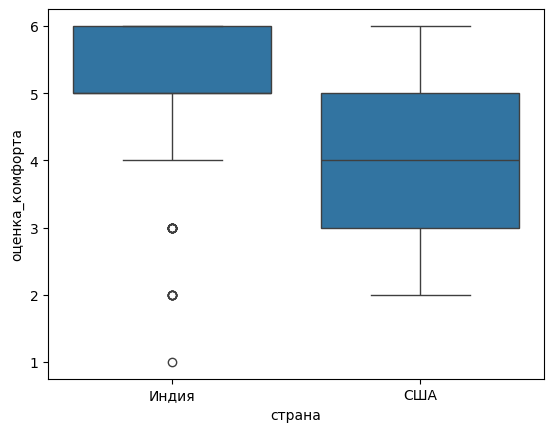

In [33]:
sns.boxplot(x='страна', y='оценка_комфорта', data=filtered_df)
# можно сделать вывод, что отличия все же есть

(array([ 8.,  0., 12.,  0.,  0., 23.,  0., 17.,  0., 12.]),
 array([2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8, 5.2, 5.6, 6. ]),
 <BarContainer object of 10 artists>)

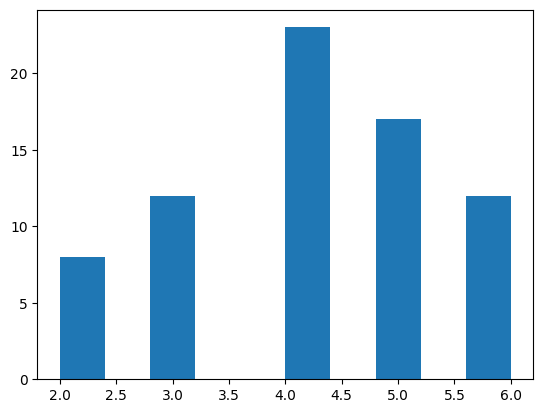

In [34]:
plt.hist(filtered_df[filtered_df['страна'] == 'США']['оценка_комфорта'])

(array([ 8.,  0., 12.,  0.,  0., 23.,  0., 17.,  0., 12.]),
 array([2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8, 5.2, 5.6, 6. ]),
 <BarContainer object of 10 artists>)

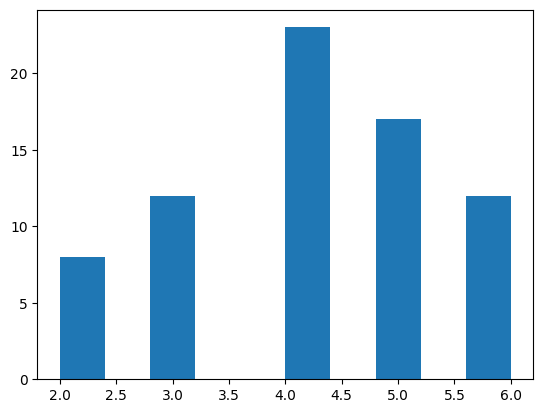

In [35]:
plt.hist(filtered_df[filtered_df['страна'] == 'США']['оценка_комфорта'])

### Дополнительные гипотезы

Проверить гипотезу о том, что средняя оценка комфорта отличается в зависимости от страны

В файле такая формулировка, предлагаю поменять на медиану, принмая во внимание тип шкалы.

Проверить корреляции:
1. 'rh_кат' и "оценка_комфорта"
механизм: люди с влажностью в помещении отличной от нормы чувствуют себя неуютно - на основании этого ставят негативные оценки
2. 'температура_удовлетворительная_%' и "оценка_комфорта"
механизм: тут проверю доку (запасная гипотеза, может придумаю что-то лучше)
3. Влияние времени года на оценку комфорта 
4. Влияет ли возрастная группа на ощущение температуры
5. 'rh_кат' и 'кол-во рекламаций', 'rh_кат' и 'ощущение_температуры(bool)'



In [36]:
# 1 rh_кат
mask = (df["rh_кат"].notna()) & (df["оценка_комфорта"].notna())
print_res(corr_for_two_nominal(
    df.loc[mask, "rh_кат"], df.loc[mask, "оценка_комфорта"]))

('! p-value', (14.749, 0.141))

In [37]:
# 2 'предпочтительное_изменение_температуры'
mask = (df["оценка_комфорта"].notna()) & (df['предпочтительное_изменение_температуры'].notna())
print_res(corr_for_two_nominal(df.loc[mask, 'предпочтительное_изменение_температуры'], df.loc[mask, "оценка_комфорта"]))

(64.001, 0.0)

In [38]:
# 2 'ощущение_температуры_(bool)'
mask = (df["оценка_комфорта"].notna()) & (df['ощущение_температуры_(bool)'].notna())
print_res(corr_for_two_nominal(df.loc[mask, 'ощущение_температуры_(bool)'], df.loc[mask, "оценка_комфорта"]))

(66.967, 0.0)

In [39]:
# 3 'ощущение_температуры_(bool)'
mask = (df["оценка_комфорта"].notna()) & (df['ощущение_движения_воздуха_(bool)'].notna())
print_res(corr_for_two_nominal(df.loc[mask, 'ощущение_движения_воздуха_(bool)'], df.loc[mask, "оценка_комфорта"]))
# pvalue = 1, абсолютный хаос)

('! p-value', (0.0, 1.0))

In [40]:
# 4 'вес'
mask = (df["оценка_комфорта"].notna()) & (df['вес'].notna())
print_res(corr_for_numeric_and_nominal('вес', "оценка_комфорта", dataframe=df.loc[mask]))

('! p-value', (6.948, 0.225, 'Краскел-Уоллес'))

In [41]:
# 6 'двери'
mask = (df["оценка_комфорта"].notna()) & (df['двери'].notna())
print_res(corr_for_two_nominal(df.loc[mask, 'двери'], df.loc[mask, "оценка_комфорта"]))
# опять хаос

('! p-value', (0.0, 1.0))

In [48]:
# 'rh_кат' и 'ощущение_температуры(bool)'
check_nominal_hyp(df['rh_кат'], df['ощущение_температуры_(bool)'])
# p-value слишком большой


'static = 0.86, p_value = 0.6500476871866048'

In [68]:
check_nominal_hyp(df['rh_кат'], df['количество_рекламаций_кат'])
# p-value слишком большой

'static = 3.42, p_value = 0.4895959376259731'

In [70]:
check_nominal_hyp(df['возраст_кат'], df['ощущение_температуры_(bool)'])
# p-value слишком большой

'static = 1.14, p_value = 0.566259026762792'

In [74]:
check_nominal_hyp(df['время_года'], df['ощущение_движения_воздуха_(bool)'])

'static = 99.37, p_value = 3.400422455364988e-19'

In [82]:
df.предпочтительное_изменение_температуры.unique()
check_nominal_hyp(df['время_года'], df['предпочтительное_изменение_температуры']
                  ), check_nominal_hyp(df['rh_кат'], df['предпочтительное_изменение_температуры'])

('static = 16.75, p_value = 0.010251766831804624',
 'static = 11.73, p_value = 0.0194897573036427')